In [1]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import sys
sys.getdefaultencoding()


'utf-8'

In [2]:
batch_size=100

def load_image(img_path,size=(32,32)):
    # 处理标签 0或者1 分两类
#     label = tf.cond(tf.strings.regex_full_match(img_path,".*/automobile/.*"),
#             lambda:tf.constant(1,tf.int8),
#             lambda:tf.constant(0,tf.int8))   
#     label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*/airplane/.*")\
#             else tf.constant(0,tf.int8)
    if tf.strings.regex_full_match(img_path,".*airplane.*"):
        label=tf.constant(0,tf.int8)
    else:
        label=tf.constant(1,tf.int8)
    print(label.op)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img,size)/255.0
    return (img,label)



In [3]:
path_train_str="./datasets/cifar2/train/*/*.jpg"
path_test_str="./datasets/cifar2/test/*/*.jpg"
ds_train= tf.data.Dataset.list_files(path_train_str) \
          .map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE) \
          .shuffle(buffer_size=1000).batch(batch_size) \
          .prefetch(tf.data.experimental.AUTOTUNE)

ds_test=tf.data.Dataset.list_files(path_test_str) \
        .map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)




name: "cond/Identity"
op: "Identity"
input: "cond"
attr {
  key: "T"
  value {
    type: DT_INT8
  }
}

name: "cond/Identity"
op: "Identity"
input: "cond"
attr {
  key: "T"
  value {
    type: DT_INT8
  }
}



tf.Tensor(1, shape=(), dtype=int8)
tf.Tensor(1, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(1, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(1, shape=(), dtype=int8)


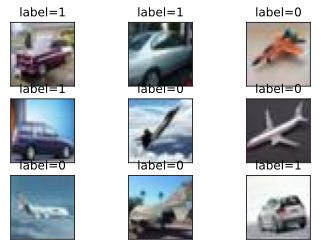

In [4]:
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='svg' 
# 把一部分图片展示出来
for i ,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,1+i)
    ax.imshow(img.numpy())
    print(label)
    ## python熟悉的人
    # ax.set_title("label = %d"%label)
    ##熟悉java的人
    ax.set_title("label="+str(label.numpy()))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [5]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)


(100, 32, 32, 3) (100,)


## 定义模型

In [6]:
#清理会话
tf.keras.backend.clear_session()

##创建 顺序模型
###输入层
inputs = layers.Input(shape=(32,32,3))
### 卷积层1
layer1 = layers.Conv2D(32,kernel_size=(3,3))(inputs)
### 池化层
layer2 = layers.MaxPool2D()(layer1)
### 卷积层2
layer3 = layers.Conv2D(64,kernel_size=(5,5))(layer2)
### 池化层2
layer4 = layers.MaxPool2D()(layer3)
## dropout 层
dropout = layers.Dropout(rate=0.1)(layer4)
##拉平
layer5 = layers.Flatten()(dropout)
## 全连接层
dense =layers.Dense(32,activation='relu')(layer5)
outputs = layers.Dense(1,activation='sigmoid')(dense)

model =models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

In [7]:
## 训练模型

import datetime
logdir="./datasets/keras_models/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensor_board_callback=tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=["accuracy"]
)

history = model.fit(ds_train,epochs=10,validation_data=ds_test,
                    callbacks=[tensor_board_callback],workers=4)

Epoch 1/10
100/100 [==============================] - 18s 176ms/step - loss: 0.4559 - accuracy: 0.7851 - val_loss: 0.3223 - val_accuracy: 0.8565

In [8]:
#%load_ext tensorboard
#%tensorboard --logdir ./datasets/keras_models
from tensorboard import notebook
notebook.list()
notebook.start("--logdir ./datasets/keras_models")


No known TensorBoard instances running.


Launching TensorBoard...

In [9]:
import pandas as pd
dfhistory = pd.DataFrame(history.history)
dfhistory.index=range(1,len(dfhistory)+1)

dfhistory.index.name="epoch"

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.455888,0.7851,0.322319,0.8565
2,0.324889,0.8604,0.270460,0.8940
3,0.266077,0.8873,0.231808,0.9045
4,0.215022,0.9137,0.197384,0.9205
5,0.190491,0.9245,0.176110,0.9260
6,0.168518,0.9328,0.168917,0.9340
7,0.145546,0.9432,0.163698,0.9405
8,0.129075,0.9519,0.155102,0.9405
9,0.110604,0.9579,0.160037,0.9355


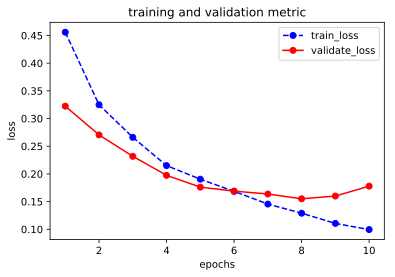

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

import matplotlib.pyplot as plt

def plot_metric(history,metric):
    train_metric= history.history[metric]
    val_metric = history.history[
        'val_'+metric]
    epochs=range(1,len(train_metric)+1)
    plt.plot(epochs,train_metric,'bo--')
    plt.plot(epochs,val_metric,'ro-')
    plt.title("training and validation metric")
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.legend(["train_"+metric,"validate_"+metric])
    plt.show()

plot_metric(history,"loss")

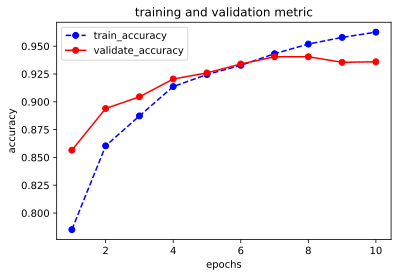

In [11]:
plot_metric(history,'accuracy')



In [12]:
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 1s 62ms/step - loss: 0.1780 - accuracy: 0.9360

In [13]:
## 模型的使用
model.predict(ds_test)

for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

[[2.4373084e-01]
 [9.8255277e-04]
 [9.9055791e-01]
 [5.3979325e-01]
 [6.8867207e-04]
 [9.9972486e-01]
 [1.9806623e-04]
 [4.3230882e-01]
 [5.7976530e-07]
 [9.9410868e-01]
 [4.4578087e-06]
 [1.7305225e-02]
 [9.3477392e-01]
 [8.4965801e-01]
 [1.7983282e-01]
 [1.7562509e-04]
 [4.7541067e-01]
 [1.7426938e-01]
 [9.3414748e-01]
 [2.1680272e-03]]


## 保存模型


In [14]:
# 保存权重
model.save_weights("./model-weights/0-2.ckpt",save_format='tf')

#保存模型及其值
model.save("./model/0-2",save_format='tf')

#加载模型
model_load = tf.keras.models.load_model("./model/0-2")
model_load.evaluate(ds_test)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model/0-2\assets
20/20 [==============================] - 1s 62ms/step - loss: 0.1780 - accuracy: 0.9360

[0.17796370387077332, 0.9359999895095825]